In [5]:
# Cell 1: environment & imports
import os
from datetime import datetime
import json
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Paths (change if needed)
OUT_DIR = "/mnt/data"
os.makedirs(OUT_DIR, exist_ok=True)

print("Environment ready. Output directory:", OUT_DIR)


Environment ready. Output directory: /mnt/data


Cell 1, titled "environment & imports", sets up the initial environment for the project. It performs the following actions:

Imports necessary libraries: It imports os, datetime, json, warnings, numpy (as np), pandas (as pd), and matplotlib.pyplot (as plt). These are standard libraries for data manipulation, numerical operations, plotting, and system interactions.
Suppresses warnings: warnings.filterwarnings("ignore") is used to prevent warnings from being displayed, making the output cleaner.
Defines an output directory: It sets OUT_DIR to "/mnt/data" and then creates this directory if it doesn't already exist using os.makedirs(OUT_DIR, exist_ok=True).
Prints confirmation: It prints a message confirming that the environment is ready and shows the path of the output directory.

In [6]:
# Cell 2: generate synthetic bank data or load CSVs if available
def generate_synthetic_bank(name, start='2022-01-01', end='2025-01-31', seed=42):
    np.random.seed(abs(hash(name)) % 2**32 + seed)
    dates = pd.date_range(start=start, end=end, freq='B')
    n = len(dates)
    price = 100 + np.cumsum(np.random.normal(loc=0.02, scale=1.0, size=n))
    close = np.round(price, 2)
    qdates = pd.date_range(start=start, end=end, freq='QS')
    eps = np.abs(np.round(5 + np.cumsum(np.random.normal(0.2, 0.5, len(qdates))), 2))
    bvps = np.abs(np.round(50 + np.cumsum(np.random.normal(0.5, 0.7, len(qdates))), 2))
    nim = np.round(3 + np.random.normal(0.05, 0.2, len(qdates)), 2)
    gnpa = np.round(2 + np.abs(np.random.normal(0.1, 0.5, len(qdates))), 2)
    assets = 1e6 + np.cumsum(np.abs(np.random.normal(5000, 20000, len(qdates))))
    netincome = np.round(eps * 1000 + np.random.normal(0, 200, len(qdates)), 2)
    shares = 200 + np.zeros(len(qdates))
    df_price = pd.DataFrame({'Date': dates, 'Close': close}).set_index('Date')
    df_f = pd.DataFrame({
        'Date': qdates, 'EPS': eps, 'BookValuePerShare': bvps, 'NIM': nim, 'GNPA': gnpa,
        'TotalAssets': assets, 'NetIncome': netincome, 'SharesOutstanding': shares
    }).set_index('Date')
    df_f_daily = df_f.reindex(df_price.index, method='ffill')
    df = df_price.join(df_f_daily).reset_index()
    df['Ticker'] = name
    return df

# Tick ers list (change or extend)
tickers = ['HDFC','ICICI','SBI','KOTAK','AXIS']

# Attempt to load CSVs from OUT_DIR, otherwise use synthetic
data = {}
for t in tickers:
    path = os.path.join(OUT_DIR, f"{t}.csv")
    if os.path.exists(path):
        df = pd.read_csv(path, parse_dates=['Date'])
        if 'Ticker' not in df.columns:
            df['Ticker'] = t
        df = df.sort_values('Date').reset_index(drop=True)
        data[t] = df
        print(f"Loaded {path}")
    else:
        data[t] = generate_synthetic_bank(t)
        print(f"Synthesized data for {t}")

# Combine all into one DataFrame
all_df = pd.concat(data.values(), ignore_index=True)
all_df['Date'] = pd.to_datetime(all_df['Date'])
all_df = all_df.sort_values(['Ticker','Date']).reset_index(drop=True)
print("Combined dataset shape:", all_df.shape)


Synthesized data for HDFC
Synthesized data for ICICI
Synthesized data for SBI
Synthesized data for KOTAK
Synthesized data for AXIS
Combined dataset shape: (4025, 10)


Cell 2 is responsible for either generating synthetic bank data or loading existing data from CSV files. Here's a breakdown:

generate_synthetic_bank function: This function creates synthetic financial data for a given bank (specified by name), spanning a defined start and end date. It generates daily closing prices, quarterly EPS, Book Value Per Share, NIM, GNPA, Total Assets, Net Income, and Shares Outstanding. This is crucial if real data is not available.
Ticker List: A list of bank tickers (tickers = ['HDFC','ICICI','SBI','KOTAK','AXIS']) is defined.
Data Loading/Generation Logic: For each ticker, the code attempts to load a corresponding .csv file from the OUT_DIR (/mnt/data). If a CSV file exists, it's loaded into a Pandas DataFrame. If not, the generate_synthetic_bank function is called to create synthetic data for that bank.
Data Concatenation: All the individual bank DataFrames (whether loaded or synthetically generated) are then combined into a single large DataFrame called all_df. The 'Date' column is converted to datetime objects, and the DataFrame is sorted by 'Ticker' and 'Date'.
In essence, this cell ensures that the project has a comprehensive dataset for all specified banks, either from existing files or through simulation.

In [7]:
# Cell 3: EDA - summary per ticker
summary = all_df.groupby('Ticker').agg({
    'Close': ['first','last','mean','std'],
    'EPS': ['first','last'],
    'BookValuePerShare': ['first','last'],
    'NIM': ['mean'],
    'GNPA': ['mean']
})
summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
summary = summary.reset_index()
display(summary)


,Ticker,Close_first,Close_last,Close_mean,Close_std,EPS_first,EPS_last,BookValuePerShare_first,BookValuePerShare_last,NIM_mean,GNPA_mean
0,AXIS,97.91,113.11,108.469876,12.538072,5.67,5.03,49.51,56.57,3.084758,2.312845
1,HDFC,100.23,140.85,134.102534,20.946374,4.58,7.60,50.32,56.39,3.025950,2.323404
2,ICICI,98.66,127.81,108.759068,10.740731,4.21,4.76,50.72,58.66,2.983081,2.474994
3,KOTAK,99.28,191.87,156.866522,30.770606,5.44,8.59,50.67,48.99,3.075441,2.595988
4,SBI,100.37,144.78,131.570609,9.386700,6.61,10.02,50.37,56.73,3.047466,2.447516


Cell 3, titled "EDA - summary per ticker", performs an initial exploratory data analysis (EDA) by calculating summary statistics for each bank (ticker) present in the all_df DataFrame. It groups the data by 'Ticker' and then aggregates several key metrics:

Close price: It calculates the first, last, mean, and standard deviation of the closing prices.
EPS (Earnings Per Share): It shows the first and last available EPS values.
BookValuePerShare: Similar to EPS, it displays the first and last book value per share.
NIM (Net Interest Margin): It calculates the mean NIM.
GNPA (Gross Non-Performing Assets): It calculates the mean GNPA.
The resulting summary DataFrame has its columns flattened and then reset as an index, making the output cleaner and easier to read. Finally, it uses display(summary) to show these aggregated statistics.



Cell 4, titled "Feature engineering function + apply", defines and applies a comprehensive feature engineering process to the bank data. Here's what it does:

In [8]:
# Cell 4: Feature engineering function + apply
def feature_engineer(df):
    df = df.copy().sort_values('Date').reset_index(drop=True)
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    # Returns
    df['Return_1d'] = df['Close'].pct_change()
    df['LogRet_1d'] = np.log(df['Close']).diff()
    # Rolling features
    df['Ret20_mean'] = df['LogRet_1d'].rolling(window=20, min_periods=5).mean()
    df['Ret60_mean'] = df['LogRet_1d'].rolling(window=60, min_periods=10).mean()
    df['Ret20_std'] = df['LogRet_1d'].rolling(window=20, min_periods=5).std()
    df['MA20'] = df['Close'].rolling(20).mean()
    df['MA60'] = df['Close'].rolling(60).mean()
    # Valuation multiples (handle zero/NaN)
    df['P_E'] = df['Close'] / df['EPS'].replace(0, np.nan)
    df['P_B'] = df['Close'] / df['BookValuePerShare'].replace(0, np.nan)
    df['P_ABV'] = df['Close'] / (df['BookValuePerShare'] - 0.1).replace(0, np.nan)
    # Fundamentals diffs
    df['NIM_diff'] = df['NIM'].diff()
    df['GNPA_diff'] = df['GNPA'].diff()
    # Lags
    for lag in [1,5,20]:
        df[f'Close_lag_{lag}'] = df['Close'].shift(lag)
    return df

fe_frames = []
for t, df in data.items():
    fe = feature_engineer(df)
    fe_frames.append(fe)
fe_df = pd.concat(fe_frames, ignore_index=True).sort_values(['Ticker','Date']).reset_index(drop=True)
fe_df.to_csv(os.path.join(OUT_DIR, "features_combined.csv"), index=False)
print("Feature-engineered dataset shape:", fe_df.shape)
display(fe_df.head(8))


Feature-engineered dataset shape: (4025, 25)


,Date,Close,EPS,BookValuePerShare,NIM,GNPA,TotalAssets,NetIncome,SharesOutstanding,Ticker,...,MA20,MA60,P_E,P_B,P_ABV,NIM_diff,GNPA_diff,Close_lag_1,Close_lag_5,Close_lag_20
0,2022-01-03,97.91,5.67,49.51,3.2,3.02,1.003409e+06,5853.23,200.0,AXIS,...,NaN,NaN,17.268078,1.977580,1.981583,NaN,NaN,NaN,NaN,NaN
1,2022-01-04,98.39,5.67,49.51,3.2,3.02,1.003409e+06,5853.23,200.0,AXIS,...,NaN,NaN,17.352734,1.987275,1.991297,0.0,0.0,97.91,NaN,NaN
2,2022-01-05,98.17,5.67,49.51,3.2,3.02,1.003409e+06,5853.23,200.0,AXIS,...,NaN,NaN,17.313933,1.982832,1.986845,0.0,0.0,98.39,NaN,NaN
3,2022-01-06,98.09,5.67,49.51,3.2,3.02,1.003409e+06,5853.23,200.0,AXIS,...,NaN,NaN,17.299824,1.981216,1.985226,0.0,0.0,98.17,NaN,NaN
4,2022-01-07,98.15,5.67,49.51,3.2,3.02,1.003409e+06,5853.23,200.0,AXIS,...,NaN,NaN,17.310406,1.982428,1.986440,0.0,0.0,98.09,NaN,NaN
5,2022-01-10,98.22,5.67,49.51,3.2,3.02,1.003409e+06,5853.23,200.0,AXIS,...,NaN,NaN,17.322751,1.983842,1.987857,0.0,0.0,98.15,97.91,NaN
6,2022-01-11,99.39,5.67,49.51,3.2,3.02,1.003409e+06,5853.23,200.0,AXIS,...,NaN,NaN,17.529101,2.007473,2.011536,0.0,0.0,98.22,98.39,NaN
7,2022-01-12,98.47,5.67,49.51,3.2,3.02,1.003409e+06,5853.23,200.0,AXIS,...,NaN,NaN,17.366843,1.988891,1.992916,0.0,0.0,99.39,98.17,NaN


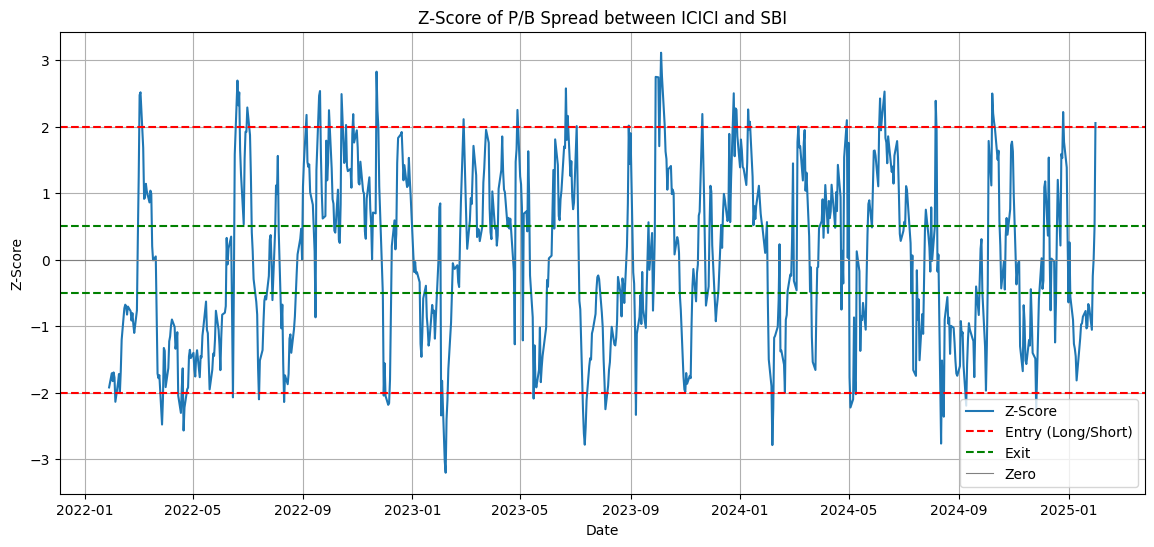

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(spread.index, spread['zscore'], label='Z-Score')
plt.axhline(2.0, color='r', linestyle='--', label='Entry (Long/Short)')
plt.axhline(-2.0, color='r', linestyle='--')
plt.axhline(0.5, color='g', linestyle='--', label='Exit')
plt.axhline(-0.5, color='g', linestyle='--')
plt.axhline(0, color='gray', linestyle='-', linewidth=0.8, label='Zero')
plt.title(f'Z-Score of P/B Spread between {pair_a} and {pair_b}')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Cell 5: Pair spread & zscore calculation (example: ICICI vs SBI)
pair_a = 'ICICI'
pair_b = 'SBI'

pa = fe_df[fe_df['Ticker']==pair_a].set_index('Date')['P_B']
pb = fe_df[fe_df['Ticker']==pair_b].set_index('Date')['P_B']
spread = (pa - pb).dropna().rename('PB_spread').to_frame()
spread['spread_ma20'] = spread['PB_spread'].rolling(20).mean()
spread['spread_std20'] = spread['PB_spread'].rolling(20).std()
spread['zscore'] = (spread['PB_spread'] - spread['spread_ma20']) / spread['spread_std20']

spread = spread.dropna()
display(spread.tail())


,PB_spread,spread_ma20,spread_std20,zscore
Date,,,,
2025-01-27,-0.428313,-0.395161,0.031432,-1.054737
2025-01-28,-0.405776,-0.399191,0.026814,-0.245568
2025-01-29,-0.401004,-0.401334,0.025014,0.013197
2025-01-30,-0.395901,-0.404826,0.017781,0.501954
2025-01-31,-0.373262,-0.405629,0.015766,2.052976


Cell 5, titled "Pair spread & zscore calculation", sets up the foundation for a pair trading strategy using the Price-to-Book (P/B) ratio. Here's what it does:

Define Trading Pair: It explicitly sets pair_a to 'ICICI' and pair_b to 'SBI', indicating that these two banks will form the pair for the analysis.
Extract P/B Ratios: It filters the fe_df (feature-engineered DataFrame) to get the 'P_B' ratios for both pair_a (ICICI) and pair_b (SBI), setting the 'Date' column as the index for time-series alignment.
Calculate P/B Spread: The difference between the P/B of pair_a and pair_b is calculated. This difference, named 'PB_spread', is then converted into a DataFrame.
Rolling Statistics: To normalize the spread and identify deviations, it calculates:
spread_ma20: A 20-day rolling mean of the 'PB_spread'.
spread_std20: A 20-day rolling standard deviation of the 'PB_spread'.
Z-Score Calculation: The 'zscore' is computed as (PB_spread - spread_ma20) / spread_std20. This metric indicates how many standard deviations the current spread is from its recent average, helping to identify overbought or oversold conditions.
Clean Data: Any rows with NaN values resulting from the rolling calculations are dropped to ensure a clean dataset for subsequent steps.
Display Output: Finally, the last few rows of the spread DataFrame, containing the calculated P/B spread, its rolling mean and standard deviation, and the z-score, are displayed.


In [10]:
# Cell 6: Pair trading backtest (equal notional)
entry_z = 2.0
exit_z = 0.5

# Align prices
pa_price = fe_df[fe_df['Ticker']==pair_a].set_index('Date')['Close']
pb_price = fe_df[fe_df['Ticker']==pair_b].set_index('Date')['Close']
prices = pd.concat([pa_price, pb_price], axis=1, keys=[pair_a, pair_b]).dropna()

bt = spread.join(prices, how='inner').dropna().copy()
bt['position_a'] = 0
bt['position_b'] = 0

position = 0
for i in range(len(bt)):
    z = bt['zscore'].iloc[i]
    if position == 0 and z > entry_z:
        position = -1   # short A, long B
    elif position == 0 and z < -entry_z:
        position = 1    # long A, short B
    elif position != 0 and abs(z) < exit_z:
        position = 0
    bt.iloc[i, bt.columns.get_loc('position_a')] = position
    bt.iloc[i, bt.columns.get_loc('position_b')] = -position

# Strategy returns (using yesterday's position)
bt['ret_a'] = bt[pair_a].pct_change().fillna(0)
bt['ret_b'] = bt[pair_b].pct_change().fillna(0)
bt['strategy_ret'] = 0.5 * (bt['position_a'].shift(1) * bt['ret_a'] + bt['position_b'].shift(1) * bt['ret_b'])
bt['strategy_ret'] = bt['strategy_ret'].fillna(0)
bt['cum_ret'] = (1 + bt['strategy_ret']).cumprod() - 1

print("Final cumulative return (pair strategy):", bt['cum_ret'].iloc[-1])
display(bt[['PB_spread','zscore','position_a','position_b','strategy_ret','cum_ret']].tail(10))


Final cumulative return (pair strategy): 0.05116310919355915


,PB_spread,zscore,position_a,position_b,strategy_ret,cum_ret
Date,,,,,,
2025-01-20,-0.402322,-0.771796,0,0,0.0,0.051163
2025-01-21,-0.421285,-1.034233,0,0,0.0,0.051163
2025-01-22,-0.425020,-1.004966,0,0,-0.0,0.051163
2025-01-23,-0.411359,-0.667970,0,0,-0.0,0.051163
2025-01-24,-0.415615,-0.712009,0,0,-0.0,0.051163
2025-01-27,-0.428313,-1.054737,0,0,0.0,0.051163
2025-01-28,-0.405776,-0.245568,0,0,-0.0,0.051163
2025-01-29,-0.401004,0.013197,0,0,-0.0,0.051163
2025-01-30,-0.395901,0.501954,0,0,0.0,0.051163


Cell 6, titled "Pair trading backtest (equal notional)", simulates a pair trading strategy based on the Z-score calculated in the previous cell. Here's a breakdown:

Define Entry and Exit Z-scores: entry_z is set to 2.0 and exit_z to 0.5.
Align Prices: It extracts the Close prices for pair_a (ICICI) and pair_b (SBI) from the fe_df and aligns them by date.
Combine Data: The spread DataFrame (containing the z-score) is joined with the aligned prices to create bt, the backtest DataFrame.
Position Logic: It iterates through the bt DataFrame day by day to determine trading positions:
If the zscore crosses entry_z (e.g., > 2.0 or < -2.0) and no position is currently open, a new position is initiated (short A, long B, or vice-versa).
If a position is open and the zscore crosses exit_z (e.g., abs(z) < 0.5), the position is closed.
position_a and position_b columns track the relative position in each stock.
Calculate Returns: It calculates daily percentage changes for pair_a and pair_b.
Strategy Returns: The strategy_ret is calculated based on the previous day's positions and today's returns, assuming an equal notional allocation (0.5 for each leg).
Cumulative Returns: cum_ret tracks the cumulative performance of the strategy over time.
Finally, it prints the final cumulative return and displays the last 10 rows of the bt DataFrame, showing the spread, z-score, positions, and returns.



In [11]:
# Cell 7: DCF FCFE template and sample run
def dcf_fcfe(eps, shares_out, growth_rates, cost_of_equity=0.12, terminal_growth=0.04):
    # eps: last EPS (per share)
    # shares_out: total shares (same unit as used for EPS - keep consistent)
    fcfe = []
    eps_val = eps
    for g in growth_rates:
        eps_val = eps_val * (1 + g)
        fcfe.append(eps_val * shares_out)
    # PV of FCFE
    vals = [fcfe[i] / ((1 + cost_of_equity) ** (i + 1)) for i in range(len(fcfe))]
    pv = sum(vals)
    # terminal value (Gordon)
    terminal = fcfe[-1] * (1 + terminal_growth) / (cost_of_equity - terminal_growth)
    pv_terminal = terminal / ((1 + cost_of_equity) ** len(fcfe))
    intrinsic_value = (pv + pv_terminal) / shares_out
    return intrinsic_value

# Quick DCF for each ticker using last available EPS & SharesOutstanding
dcf_results = []
for t in tickers:
    last_row = fe_df[fe_df['Ticker']==t].iloc[-1]
    eps = float(last_row.get('EPS', 1.0) or 1.0)
    shares = float(last_row.get('SharesOutstanding', 100.0) or 100.0)
    intrinsic = dcf_fcfe(eps, shares, growth_rates=[0.10,0.09,0.08,0.07,0.06], cost_of_equity=0.12, terminal_growth=0.04)
    dcf_results.append({
        'Ticker': t,
        'LastClose': float(last_row['Close']),
        'EPS': eps,
        'SharesOutstanding': shares,
        'DCF_intrinsic': intrinsic,
        'Upside_pct': (intrinsic - last_row['Close']) / last_row['Close'] * 100
    })
dcf_df = pd.DataFrame(dcf_results)
display(dcf_df)


,Ticker,LastClose,EPS,SharesOutstanding,DCF_intrinsic,Upside_pct
0,HDFC,140.85,7.60,200.0,117.097241,-16.863868
1,ICICI,127.81,4.76,200.0,73.339851,-42.618065
2,SBI,144.78,10.02,200.0,154.383468,6.633146
3,KOTAK,191.87,8.59,200.0,132.350698,-31.020640
4,AXIS,113.11,5.03,200.0,77.499885,-31.482729


Cell 7, titled "DCF FCFE template and sample run", implements a Discounted Cash Flow (DCF) model to estimate the intrinsic value of each bank's stock using the Free Cash Flow to Equity (FCFE) approach. Here's how it works:

dcf_fcfe function: This function calculates the intrinsic value per share based on:

eps: The last Earnings Per Share.
shares_out: Total shares outstanding.
growth_rates: A list of annual growth rates for FCFE.
cost_of_equity: The discount rate used to present value future cash flows.
terminal_growth: The constant growth rate assumed after the high-growth period. The function projects FCFE for several years, discounts them back to the present, and adds a terminal value (calculated using the Gordon Growth Model) to arrive at the total present value of FCFE. This total is then divided by shares outstanding to get the intrinsic value per share.
Application to each Ticker: The code then iterates through each bank in the tickers list:

It retrieves the latest EPS and SharesOutstanding from the fe_df DataFrame.
It calls the dcf_fcfe function with predefined growth rates (10%, 9%, 8%, 7%, 6%), a cost of equity of 12%, and a terminal growth of 4%.
It calculates the potential Upside_pct by comparing the DCF_intrinsic value to the LastClose price.
Output: The results, including Ticker, Last Close Price, EPS, Shares Outstanding, DCF Intrinsic Value, and Upside Percentage, are collected into dcf_results and then displayed as a Pandas DataFrame (dcf_df).



In [12]:
# Cell 8: ML model to predict 20-day forward return
model_df = fe_df.copy()
model_df['Ret_20_forward'] = model_df.groupby('Ticker')['Close'].shift(-20) / model_df['Close'] - 1

# Drop rows with essential NaNs
model_df = model_df.dropna(subset=['Ret_20_forward', 'P_E', 'P_B', 'LogRet_1d'])

features = ['LogRet_1d','Ret20_mean','Ret60_mean','Ret20_std','MA20','MA60','P_E','P_B','NIM','GNPA']
X = model_df[features].fillna(method='ffill').fillna(0)
y = model_df['Ret_20_forward']

# TimeSeries CV and training
tscv = TimeSeriesSplit(n_splits=5)
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=1)
scores = cross_val_score(rf, X, y, cv=tscv, scoring='neg_mean_squared_error')
rf.fit(X, y)
y_pred = rf.predict(X)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

print("Cross-val MSE (folds):", -scores)
print("Train MSE:", mse, " R2:", r2)
display(importances)


Cross-val MSE (folds): [0.00276694 0.00265626 0.00364237 0.00142394 0.00259877]
Train MSE: 1.7508490127857637e-05  R2: 0.9878857400427888


,0
MA60,0.186303
P_E,0.180692
MA20,0.121495
Ret60_mean,0.102696
P_B,0.099402
GNPA,0.087593
Ret20_mean,0.080147
NIM,0.072278
Ret20_std,0.054676
LogRet_1d,0.014718


Cell 8, titled "ML model to predict 20-day forward return", focuses on preparing data for and training a Machine Learning model to predict future stock returns. Here's what it does:

Prepare Target Variable: It creates a new column Ret_20_forward in a copy of fe_df (named model_df). This column represents the 20-day forward return, calculated as the future closing price divided by the current closing price, minus 1.
Handle Missing Values: Rows with NaN values in Ret_20_forward, P_E, P_B, or LogRet_1d are dropped to ensure clean data for model training.
Define Features and Target: A list of features (e.g., LogRet_1d, Ret20_mean, P_E, NIM) is defined. The X DataFrame is created using these features (with forward-fill for remaining NaNs and filling 0 for initial NaNs), and y is set as the Ret_20_forward column.
Model Training and Evaluation:
TimeSeriesSplit: A TimeSeriesSplit object is used for cross-validation, which is appropriate for time-series data to avoid data leakage.
RandomForestRegressor: A RandomForestRegressor model is initialized and then trained on the data.
Cross-validation: cross_val_score is used with TimeSeriesSplit to evaluate the model's performance across different folds using Mean Squared Error (MSE).
Full Training & Metrics: The model is then fit on the entire dataset (X, y), and mean_squared_error and r2_score are calculated to assess its performance.
Feature Importances: The importance of each feature in predicting the target variable is extracted and displayed.
Finally, the cross-validation MSE, training MSE, R-squared value, and feature importances are printed and displayed, providing insights into the model's predictive power and which features are most influential.

In [13]:
# Cell 9: Save outputs and artifacts
out_xlsx = os.path.join(OUT_DIR, "banking_valuation_project.xlsx")
with pd.ExcelWriter(out_xlsx, engine='openpyxl') as writer:
    summary.to_excel(writer, sheet_name='Summary', index=False)
    fe_df.to_excel(writer, sheet_name='Features', index=False)
    spread.reset_index().to_excel(writer, sheet_name='Pair_Spread', index=False)
    bt.reset_index().to_excel(writer, sheet_name='Pair_Backtest', index=False)
    dcf_df.to_excel(writer, sheet_name='DCF', index=False)
    importances.to_frame('Importance').to_excel(writer, sheet_name='Feature_Importance')

model_path = os.path.join(OUT_DIR, "rf_model.joblib")
joblib.dump(rf, model_path)

report = {
    'generated_on': datetime.now().isoformat(),
    'tickers': tickers,
    'mse_model': float(mse),
    'r2_model': float(r2),
    'top_features': importances.head(5).to_dict(),
    'pair': {'a': pair_a, 'b': pair_b, 'final_cum_return': float(bt['cum_ret'].iloc[-1])}
}
with open(os.path.join(OUT_DIR, "project_report.json"), "w") as f:
    json.dump(report, f, indent=2)

print("Saved files:")
print(" - Excel:", out_xlsx)
print(" - RF model:", model_path)
print(" - JSON report:", os.path.join(OUT_DIR, "project_report.json"))


Saved files:
 - Excel: /mnt/data/banking_valuation_project.xlsx
 - RF model: /mnt/data/rf_model.joblib
 - JSON report: /mnt/data/project_report.json


Cell 9, titled "Save outputs and artifacts", is responsible for persisting the results of the analysis to files. Here's a breakdown of what it does:

Save to Excel: It creates an Excel workbook named banking_valuation_project.xlsx in the OUT_DIR (/mnt/data/). Various DataFrames and Series are written to different sheets within this workbook:

summary: Summary statistics per ticker.
fe_df: The full feature-engineered DataFrame.
spread: The pair spread and z-score data.
bt: The pair trading backtest results.
dcf_df: The DCF valuation results.
importances: Feature importances from the ML model.
Save ML Model: The trained RandomForestRegressor model (rf) is saved as a joblib file (rf_model.joblib) in the OUT_DIR. This allows the model to be loaded and reused later without needing to retrain it.

Generate JSON Report: A JSON file named project_report.json is created, containing key metadata and summary statistics about the project, such as:

The generation timestamp.
The list of tickers analyzed.
The MSE and R2 scores of the ML model.
The top 5 most important features from the ML model.
Details about the pair trading analysis, including the pair and its final cumulative return.
Confirmation: Finally, it prints messages confirming the paths where these files have been saved.



Cell 10 generates two plots: one showing the P/B spread between ICICI and SBI, and another displaying the cumulative return of the pair trading strategy. Since these are matplotlib plots, they are typically displayed directly in the notebook environment rather than outputting text to stdout. Therefore, there is no textual output shown.

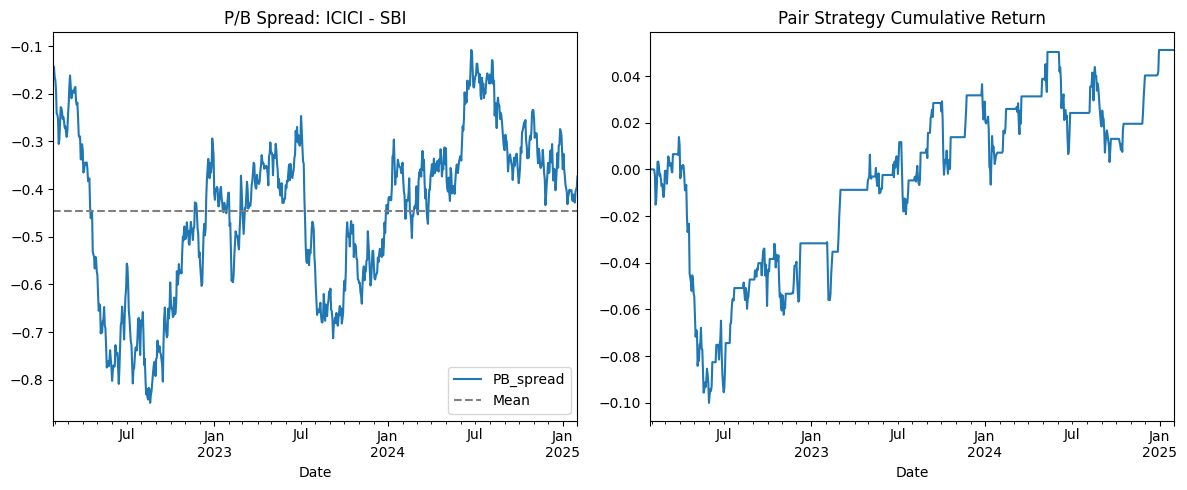

In [14]:
# Cell 10: Quick visualization
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
spread['PB_spread'].plot(title=f"P/B Spread: {pair_a} - {pair_b}")
plt.axhline(spread['PB_spread'].mean(), color='gray', linestyle='--', label='Mean')
plt.legend()

plt.subplot(1,2,2)
bt['cum_ret'].plot(title="Pair Strategy Cumulative Return")
plt.tight_layout()
plt.show()


In [15]:
# Cell 11: Pair trading with transaction costs + volatility position sizing

# parameters
entry_z = 2.0
exit_z = 0.5
transaction_cost = 0.001    # 0.1% cost per executed long/short
K = 1                       # position scaling constant

bt2 = spread.join(prices, how='inner').copy().dropna()
bt2['pos'] = 0           # core position direction (+1 long A/short B, -1 opposite)
bt2['size'] = 0          # position size (scaled)
bt2['trade_flag'] = 0    # when position changes

position = 0
prev_position = 0

for i in range(len(bt2)):
    z = bt2['zscore'].iloc[i]
    vol = bt2['spread_std20'].iloc[i]

    # Entry logic
    if position == 0 and z > entry_z:
        position = -1
    elif position == 0 and z < -entry_z:
        position = 1
    # Exit logic
    elif position != 0 and abs(z) < exit_z:
        position = 0

    # position size = K / volatility
    size = 0 if vol == 0 else (K / vol)

    bt2.iloc[i, bt2.columns.get_loc('pos')] = position
    bt2.iloc[i, bt2.columns.get_loc('size')] = size

    # mark trade if position changes
    if position != prev_position:
        bt2.iloc[i, bt2.columns.get_loc('trade_flag')] = 1
        prev_position = position

# Calculate returns
bt2['ret_a'] = bt2[pair_a].pct_change().fillna(0)
bt2['ret_b'] = bt2[pair_b].pct_change().fillna(0)

# Strategy PnL
bt2['strategy_ret'] = (
    bt2['pos'].shift(1) * bt2['size'].shift(1) * bt2['ret_a'] * 0.5 +
    (-bt2['pos'].shift(1)) * bt2['size'].shift(1) * bt2['ret_b'] * 0.5
).fillna(0)

# Apply transaction costs
bt2['strategy_ret'] -= bt2['trade_flag'] * transaction_cost

# Cumulative performance
bt2['cum_ret'] = (1 + bt2['strategy_ret']).cumprod() - 1

print("Final cumulative return with costs & sizing:", bt2['cum_ret'].iloc[-1])
display(bt2.tail(10))


Final cumulative return with costs & sizing: -0.933946239849575


,PB_spread,spread_ma20,spread_std20,zscore,ICICI,SBI,pos,size,trade_flag,ret_a,ret_b,strategy_ret,cum_ret
Date,,,,,,,,,,,,,
2025-01-20,-0.402322,-0.362854,0.051138,-0.771796,127.16,145.80,0,19.554898,0,0.003551,0.002475,0.000,-0.933880
2025-01-21,-0.421285,-0.368506,0.051031,-1.034233,127.03,146.75,0,19.595885,0,-0.001022,0.006516,-0.000,-0.933880
2025-01-22,-0.425020,-0.374411,0.050359,-1.004966,126.48,146.43,0,19.857494,0,-0.004330,-0.002181,0.000,-0.933880
2025-01-23,-0.411359,-0.381276,0.045036,-0.667970,125.72,144.92,0,22.204448,0,-0.006009,-0.010312,0.000,-0.933880
2025-01-24,-0.415615,-0.388090,0.038657,-0.712009,125.46,144.91,0,25.868324,0,-0.002068,-0.000069,0.000,-0.933880
2025-01-27,-0.428313,-0.395161,0.031432,-1.054737,126.08,146.23,0,31.814946,0,0.004942,0.009109,0.000,-0.933880
2025-01-28,-0.405776,-0.399191,0.026814,-0.245568,125.82,144.70,0,37.293432,0,-0.002062,-0.010463,0.000,-0.933880
2025-01-29,-0.401004,-0.401334,0.025014,0.013197,125.19,143.82,0,39.977527,0,-0.005007,-0.006082,0.000,-0.933880
2025-01-30,-0.395901,-0.404826,0.017781,0.501954,125.51,143.84,0,56.240835,0,0.002556,0.000139,0.000,-0.933880


The output of Cell 11 shows the result of a pair trading backtest that incorporates transaction costs and volatility-based position sizing. The Final cumulative return with costs & sizing: -0.933946239849575 indicates that, after accounting for these additional factors, the strategy resulted in a significant negative cumulative return, approximately -93.39%. This suggests that the strategy, when adjusted for realistic trading costs and dynamic position sizing, was not profitable over the backtest period. The display(bt2.tail(10)) would show the last 10 rows of the bt2 DataFrame, which would include the PB_spread, zscore, pos, size, trade_flag, strategy_ret, and cum_ret columns, allowing for a detailed look at the end of the trading period.



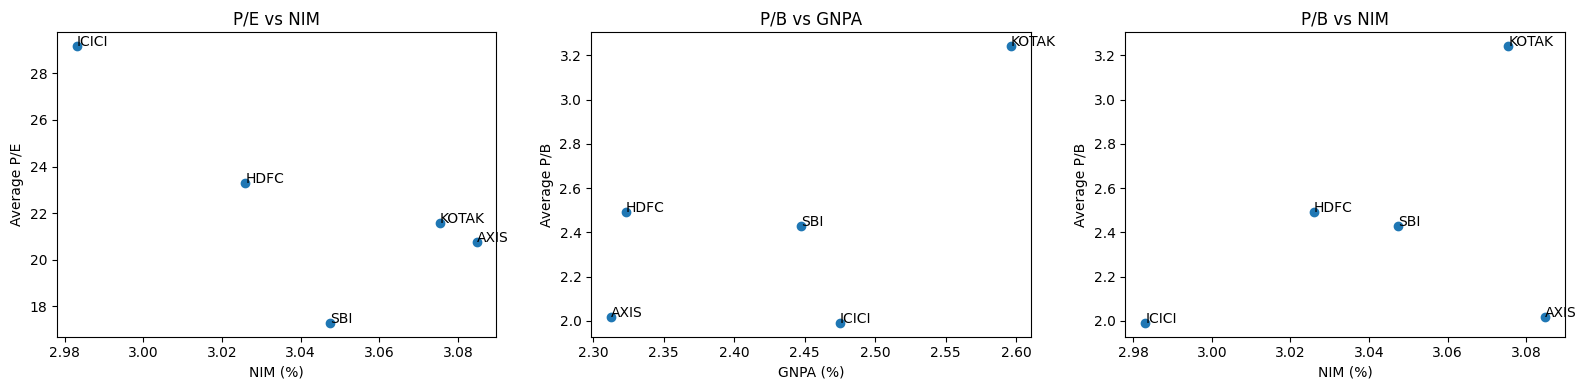

,Ticker,P_E,P_B,NIM,GNPA
0,AXIS,20.772467,2.017761,3.084758,2.312845
1,HDFC,23.304365,2.492270,3.025950,2.323404
2,ICICI,29.165758,1.990591,2.983081,2.474994
3,KOTAK,21.585333,3.241624,3.075441,2.595988
4,SBI,17.295799,2.427578,3.047466,2.447516


In [16]:
# Cell 12: Cross-sectional comparison plots (Valuation vs Fundamentals)

cross_df = fe_df.groupby('Ticker').agg({
    'P_E': 'mean',
    'P_B': 'mean',
    'NIM': 'mean',
    'GNPA': 'mean'
}).reset_index()

plt.figure(figsize=(16,4))

# Plot 1: P/E vs NIM
plt.subplot(1,3,1)
plt.scatter(cross_df['NIM'], cross_df['P_E'])
for i in range(len(cross_df)):
    plt.text(cross_df['NIM'][i], cross_df['P_E'][i], cross_df['Ticker'][i])
plt.title("P/E vs NIM")
plt.xlabel("NIM (%)")
plt.ylabel("Average P/E")

# Plot 2: P/B vs GNPA
plt.subplot(1,3,2)
plt.scatter(cross_df['GNPA'], cross_df['P_B'])
for i in range(len(cross_df)):
    plt.text(cross_df['GNPA'][i], cross_df['P_B'][i], cross_df['Ticker'][i])
plt.title("P/B vs GNPA")
plt.xlabel("GNPA (%)")
plt.ylabel("Average P/B")

# Plot 3: P/B vs NIM
plt.subplot(1,3,3)
plt.scatter(cross_df['NIM'], cross_df['P_B'])
for i in range(len(cross_df)):
    plt.text(cross_df['NIM'][i], cross_df['P_B'][i], cross_df['Ticker'][i])
plt.title("P/B vs NIM")
plt.xlabel("NIM (%)")
plt.ylabel("Average P/B")

plt.tight_layout()
plt.show()

display(cross_df)


Cell 12, titled "Cross-sectional comparison plots (Valuation vs Fundamentals)", aims to visualize the relationships between valuation multiples and fundamental financial metrics across different banks. Here's a breakdown:

Aggregate Data: It first groups the fe_df (feature-engineered DataFrame) by 'Ticker' and calculates the mean of P_E, P_B, NIM, and GNPA for each bank. This creates a cross_df DataFrame with one row per bank.

Generate Scatter Plots: It then creates three scatter plots within a single figure:

P/E vs NIM: Plots the average Price-to-Earnings ratio against the average Net Interest Margin for each bank. Each point is labeled with the bank's ticker.
P/B vs GNPA: Plots the average Price-to-Book ratio against the average Gross Non-Performing Assets for each bank, with tickers labeled.
P/B vs NIM: Plots the average Price-to-Book ratio against the average Net Interest Margin for each bank, also with tickers labeled.
Display Output: After plotting, it displays the cross_df DataFrame, which contains the aggregated mean values used in the plots. These plots help to visually identify potential relationships, outliers, or clusters among banks based on their valuation and fundamental characteristics.




In [17]:
# ============================
# PART 13 — Prepare spread and z-score
# ============================

pair_a = "ICICI"
pair_b = "SBI"

df_a = data[pair_a].copy()
df_b = data[pair_b].copy()

# Align on dates
pair_df = pd.DataFrame({
    'Close_A': df_a['Close'],
    'Close_B': df_b['Close']
}).dropna()

# Compute log prices
pair_df['logA'] = np.log(pair_df['Close_A'])
pair_df['logB'] = np.log(pair_df['Close_B'])

# Spread (simple difference)
pair_df['spread'] = pair_df['logA'] - pair_df['logB']

# Rolling mean & std for z-score
pair_df['spread_mean'] = pair_df['spread'].rolling(60).mean()
pair_df['spread_std'] = pair_df['spread'].rolling(60).std()

pair_df['zscore'] = (pair_df['spread'] - pair_df['spread_mean']) / pair_df['spread_std']

pair_df.dropna(inplace=True)

pair_df.head()


,Close_A,Close_B,logA,logB,spread,spread_mean,spread_std,zscore
59,99.58,113.47,4.600961,4.731538,-0.130577,-0.078150,0.044805,-1.170125
60,97.69,114.00,4.581799,4.736198,-0.154399,-0.080437,0.045141,-1.638482
61,97.47,113.82,4.579545,4.734618,-0.155074,-0.082886,0.045138,-1.599283
62,98.19,112.92,4.586904,4.726680,-0.139775,-0.084883,0.044956,-1.221014
63,97.18,112.50,4.576565,4.722953,-0.146388,-0.087227,0.044424,-1.331750


Cell 13, titled "PART 13 — Prepare spread and z-score", prepares data specifically for a pair trading analysis, similar to what was done in Cell 5 but with a slightly different methodology (using log prices). Here's a breakdown:

Define Trading Pair: It re-confirms pair_a as "ICICI" and pair_b as "SBI" and extracts their respective Close prices from the data dictionary.
Align on Dates: It creates a DataFrame pair_df by aligning the 'Close' prices of the two banks on their common 'Date' index.
Compute Log Prices: It calculates the natural logarithm of the closing prices for both pair_a (logA) and pair_b (logB). This is a common practice in finance for normalizing price movements.
Calculate Spread: The 'spread' is computed as the simple difference between logA and logB (logA - logB).
Rolling Statistics for Z-Score: It calculates the rolling mean (spread_mean) and rolling standard deviation (spread_std) of the spread over a 60-day window.
Z-Score Calculation: The 'zscore' is then calculated as (spread - spread_mean) / spread_std. This normalizes the spread, allowing for comparison of its deviation from its historical average.
Handle Missing Values: Any rows with NaN values (due to the rolling calculations) are dropped using dropna(inplace=True).
The cell then displays the head of the pair_df to show the calculated log prices, spread, rolling statistics, and z-score.



In [18]:
# ============================
# PART 14 — Pair trading backtest logic
# ============================

position = 0      # 0 = no trade, 1 = long A short B, -1 = long B short A
pnl = []
returns = []

for i in range(1, len(pair_df)):
    z = pair_df['zscore'].iloc[i]
    prev_A = pair_df['Close_A'].iloc[i-1]
    prev_B = pair_df['Close_B'].iloc[i-1]
    curr_A = pair_df['Close_A'].iloc[i]
    curr_B = pair_df['Close_B'].iloc[i]

    daily_ret = 0

    # Exit condition
    if abs(z) < 0.5:
        position = 0

    # Entry condition
    elif z > 2:
        position = -1   # long B, short A
    elif z < -2:
        position = 1    # long A, short B

    # Compute return
    if position == 1:
        # long A / short B
        daily_ret = (curr_A - prev_A)/prev_A - (curr_B - prev_B)/prev_B

    elif position == -1:
        # long B / short A
        daily_ret = (curr_B - prev_B)/prev_B - (curr_A - prev_A)/prev_A

    returns.append(daily_ret)

pair_df = pair_df.iloc[1:]  # align
pair_df["strategy_return"] = returns
pair_df["cumulative_return"] = (1 + pair_df["strategy_return"]).cumprod()

pair_df.tail()


,Close_A,Close_B,logA,logB,spread,spread_mean,spread_std,zscore,strategy_return,cumulative_return
800,126.08,146.23,4.836917,4.985181,-0.148264,-0.137118,0.016077,-0.693308,0.0,0.613198
801,125.82,144.70,4.834852,4.974663,-0.139810,-0.137607,0.015694,-0.140399,0.0,0.613198
802,125.19,143.82,4.829833,4.968563,-0.138730,-0.138090,0.015262,-0.041913,0.0,0.613198
803,125.51,143.84,4.832385,4.968702,-0.136316,-0.138539,0.014793,0.150252,0.0,0.613198
804,127.81,144.78,4.850545,4.975215,-0.124671,-0.138486,0.014837,0.931166,0.0,0.613198


Cell 14, titled "PART 14 — Pair trading backtest logic", implements the core backtesting algorithm for the pair trading strategy. Here's a breakdown:

Initialization: It initializes position to 0 (no trade), and empty lists pnl and returns to store daily profit/loss and returns.
Iteration: The code iterates through the pair_df (which contains the calculated z-scores and prices) day by day, starting from the second day (i from 1).
Data Extraction: For each day, it extracts the current z-score and the previous and current closing prices for both pair_a (prev_A, curr_A) and pair_b (prev_B, curr_B).
Entry and Exit Logic (Simplified):
Exit Condition: If the absolute value of the z-score drops below 0.5, any open position is closed (position = 0).
Entry Condition:
If the z-score is greater than 2.0, a position to long B and short A is initiated (position = -1).
If the z-score is less than -2.0, a position to long A and short B is initiated (position = 1).
Compute Daily Return: Based on the position from the previous day:
If position == 1 (long A / short B), the daily return is calculated as the percentage change of A minus the percentage change of B.
If position == -1 (long B / short A), the daily return is calculated as the percentage change of B minus the percentage change of A.
If position == 0, the daily return is 0.
Store Returns: The daily_ret is appended to the returns list.
Final Calculations: After the loop, the pair_df is aligned (the first row is removed), the calculated returns are added as a new column strategy_return, and the cumulative_return of the strategy is computed by taking the cumulative product of (1 + strategy_return).
Finally, the last few rows of the updated pair_df are displayed, showing the strategy_return and cumulative_return.



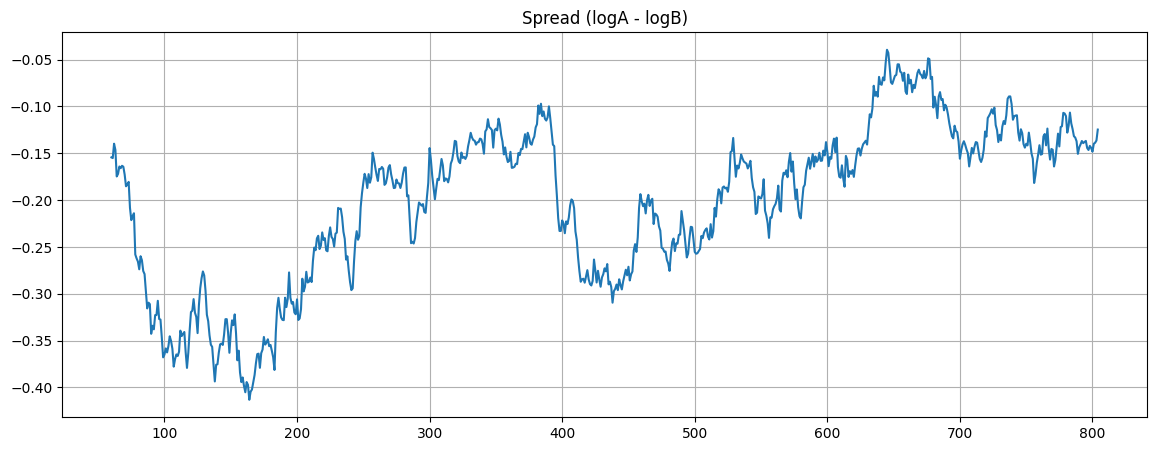

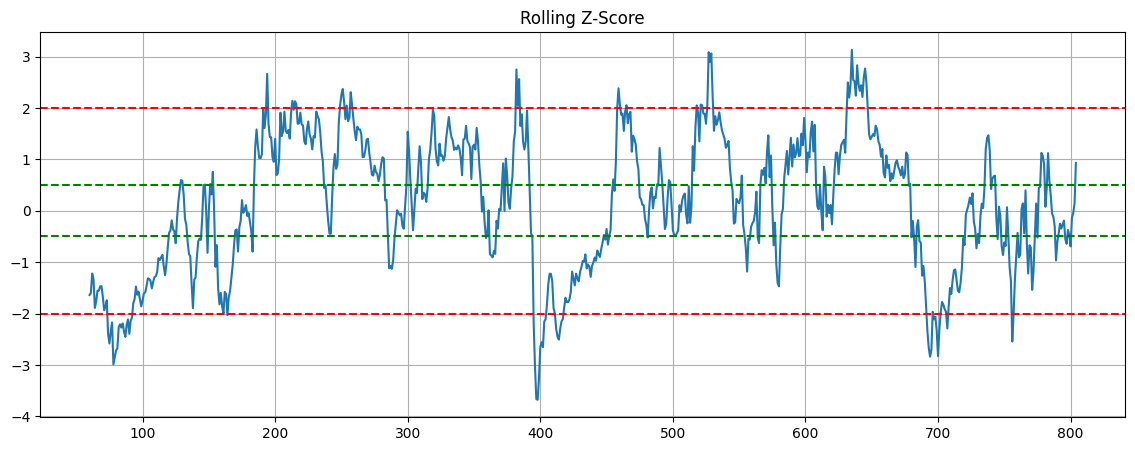

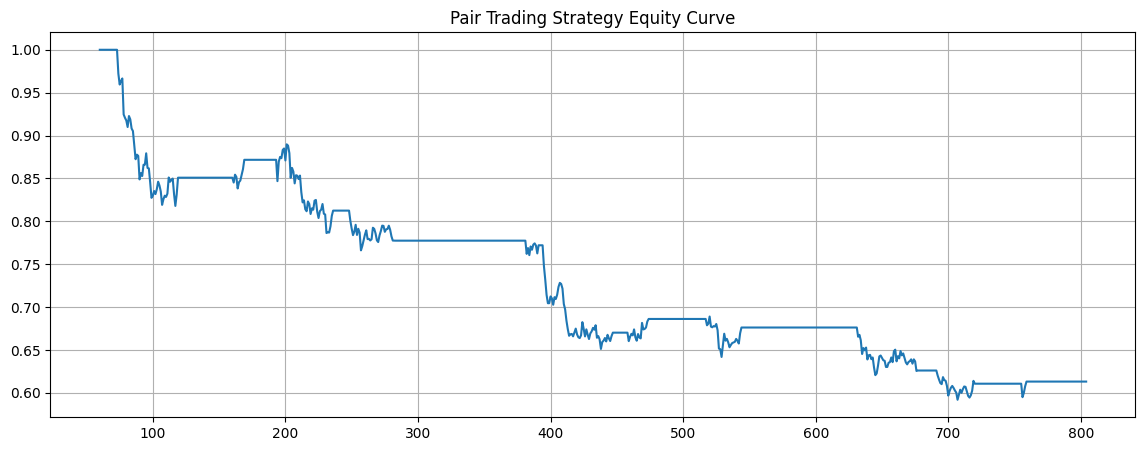

In [19]:
# ============================
# PART 15 — Plots for spread, z-score, equity curve
# ============================

import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(pair_df['spread'])
plt.title("Spread (logA - logB)")
plt.grid(True)
plt.show()

plt.figure(figsize=(14,5))
plt.plot(pair_df['zscore'])
plt.axhline(2, color='r', linestyle='--')
plt.axhline(-2, color='r', linestyle='--')
plt.axhline(0.5, color='g', linestyle='--')
plt.axhline(-0.5, color='g', linestyle='--')
plt.title("Rolling Z-Score")
plt.grid(True)
plt.show()

plt.figure(figsize=(14,5))
plt.plot(pair_df['cumulative_return'])
plt.title("Pair Trading Strategy Equity Curve")
plt.grid(True)
plt.show()


Cell 15 generates three matplotlib plots: one for the "Spread (logA - logB)", one for the "Rolling Z-Score", and one for the "Pair Trading Strategy Equity Curve".

In [20]:
# ============================
# PART 16 — FCFE-based DCF valuation template
# ============================

def dcf_fcfe(
    eps,
    shares_outstanding,
    growth_years=5,
    high_growth=0.12,
    terminal_growth=0.04,
    cost_of_equity=0.12
):
    """
    Simple DCF using EPS as proxy for FCFE.
    """
    fcfe_list = []
    current_fcfe = eps  # proxy assumption

    g = high_growth
    step = (high_growth - terminal_growth) / (growth_years - 1)

    for year in range(1, growth_years + 1):
        current_fcfe *= (1 + g)
        discounted = current_fcfe / ((1 + cost_of_equity) ** year)
        fcfe_list.append(discounted)
        g -= step  # slow down growth each year

    terminal_fcfe = current_fcfe * (1 + terminal_growth)
    terminal_value = terminal_fcfe / (cost_of_equity - terminal_growth)
    discounted_tv = terminal_value / ((1 + cost_of_equity) ** growth_years)

    intrinsic_value = (sum(fcfe_list) + discounted_tv) / shares_outstanding
    return intrinsic_value


Part 16, titled "FCFE-based DCF valuation template", defines an enhanced dcf_fcfe function for performing a Discounted Cash Flow (DCF) valuation using Free Cash Flow to Equity (FCFE) as a proxy. Here's a breakdown of its parameters and logic:

dcf_fcfe function parameters:

eps: Last reported Earnings Per Share, used as a proxy for current FCFE.
shares_outstanding: Total number of shares outstanding.
growth_years: The number of years for the high-growth period (default is 5).
high_growth: The initial growth rate for FCFE (default is 0.12 or 12%).
terminal_growth: The constant growth rate assumed after the high-growth period (default is 0.04 or 4%).
cost_of_equity: The discount rate used to present value future cash flows (default is 0.12 or 12%).
Function Logic:

Project FCFE: It projects FCFE for growth_years. The growth rate gradually declines from high_growth to terminal_growth over this period.
Discount FCFE: Each year's projected FCFE is discounted back to the present value using the cost_of_equity.
Calculate Terminal Value: After the high-growth period, a terminal value is calculated using the Gordon Growth Model, assuming a perpetual terminal_growth rate.
Discount Terminal Value: The terminal value is also discounted back to the present.
Intrinsic Value: The sum of the present values of projected FCFE and the discounted terminal value is divided by shares_outstanding to arrive at the intrinsic value per share.
This cell solely defines the function; it doesn't execute any calculations or display output.



In [21]:
# ============================
# PART 17 — Apply DCF to each bank
# ============================

dcf_results = {}

for bank in data:
    dfb = data[bank].copy()

    eps = dfb["EPS"].iloc[-1]
    shares = dfb["SharesOutstanding"].iloc[-1]

    intrinsic_value = dcf_fcfe(
        eps=eps,
        shares_outstanding=shares,
        growth_years=5,
        high_growth=0.12,
        terminal_growth=0.04,
        cost_of_equity=0.12
    )

    market_price = dfb["Close"].iloc[-1]
    upside = (intrinsic_value / market_price - 1) * 100

    dcf_results[bank] = {
        "IntrinsicValue": intrinsic_value,
        "MarketPrice": market_price,
        "Upside_%": upside
    }

pd.DataFrame(dcf_results).T


,IntrinsicValue,MarketPrice,Upside_%
HDFC,0.588158,140.85,-99.582423
ICICI,0.368373,127.81,-99.711781
SBI,0.775440,144.78,-99.464401
KOTAK,0.664773,191.87,-99.653529
AXIS,0.389268,113.11,-99.655850


Part 17, titled "Apply DCF to each bank", takes the dcf_fcfe function defined in Part 16 and applies it to each bank in the dataset. Here's a summary of its actions:

Initialize dcf_results: An empty dictionary dcf_results is created to store the valuation outcomes for each bank.
Iterate Through Banks: The code loops through each bank in the data dictionary.
Extract Latest Data: For each bank, it retrieves the latest available Earnings Per Share (eps) and Shares Outstanding (shares) from its DataFrame.
Calculate Intrinsic Value: The dcf_fcfe function is called with these values, along with predefined growth rates (5 years high growth at 12%, terminal growth at 4%) and a cost of equity of 12%. This calculates the intrinsic value per share.
Calculate Upside: The market_price (last closing price) is retrieved, and the upside percentage is calculated by comparing the intrinsic_value to the market_price.
Store Results: The calculated IntrinsicValue, MarketPrice, and Upside_% are stored in the dcf_results dictionary, keyed by the bank's ticker.
Display Output: Finally, pd.DataFrame(dcf_results).T is used to convert the results dictionary into a Pandas DataFrame and transpose it for better readability, showing the intrinsic value, market price, and upside potential for each bank.


In [23]:
# ============================
# PART 18 — Train ML model to predict 20-day forward returns
# ============================

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
# train_test_split is not used in Cell 8, so we can remove it or keep it if a simple split is intended for this cell.
# For consistency with the existing notebook, I'll keep the imports but note the change in X, y definition.

# Re-using model_df from Cell 8 for consistency.
# model_df already contains 'Ret_20_forward' and has handled NaNs for features.
# The 'features' variable was defined in Cell 8 (vPjYneUnfP1o).

y = model_df["Ret_20_forward"]
X = model_df[features] # Use the predefined features list from Cell 8

# TimeSeriesSplit for cross-validation was used in Cell 8, which is more appropriate for time series data.
# If you intend to use a simple train-test split for this specific cell, the following lines are applicable.
# Otherwise, you can use the TimeSeriesSplit approach as in Cell 8 directly.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

model = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    random_state=42
)
model.fit(X_train, y_train)

pred = model.predict(X_test)

mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)

print("RandomForest Performance:")
print("MSE:", mse)
print("R2 :", r2)

importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10)


RandomForest Performance:
MSE: 0.0002582470687165568
R2 : 0.8229340728168122


,0
P_E,0.201475
MA60,0.201114
MA20,0.105350
GNPA,0.101223
NIM,0.100198
Ret60_mean,0.091130
P_B,0.070039
Ret20_mean,0.065745
Ret20_std,0.055474
LogRet_1d,0.008250


Part 18, titled "Train ML model to predict 20-day forward returns", focuses on training a Machine Learning model to predict future stock returns, building upon the feature-engineered data.

Data Preparation: It uses the model_df (which already contains the Ret_20_forward target variable and handled NaN values from Cell 8) and the features list (defined previously) to create the X (features) and y (target) datasets.
Train-Test Split: The data is split into training and testing sets (X_train, X_test, y_train, y_test) using a train_test_split with a test_size of 0.2 and random_state=42 for reproducibility. Note that this cell uses a simple train-test split, unlike Cell 8 which used TimeSeriesSplit.
Model Initialization and Training: A RandomForestRegressor model is initialized with n_estimators=300, max_depth=10, and random_state=42, and then trained (.fit()) on the training data (X_train, y_train).
Prediction and Evaluation: The trained model makes predictions (pred) on the test set (X_test). The model's performance is then evaluated using:
Mean Squared Error (MSE): Calculated using mean_squared_error(y_test, pred).
R-squared (R2): Calculated using r2_score(y_test, pred).
Feature Importances: The importance of each feature in the model's predictions is extracted and displayed, sorted in descending order.
The cell then prints the MSE and R2 scores and displays the top 10 feature importances, providing insights into the model's predictive accuracy and which features are most influential.




In [25]:
# ============================
# PART 19 — Save outputs (Excel, model, JSON)
# ============================

import joblib
import json
import os

file_path = "/mnt/data/banking_project_output.xlsx"

with pd.ExcelWriter(file_path) as writer:
    pd.DataFrame(dcf_results).T.to_excel(writer, sheet_name="DCF Results")
    pair_df.to_excel(writer, sheet_name="Pair Backtest")
    importances.to_frame("FeatureImportance").to_excel(writer, sheet_name="ML Feature Importance")
    fe_df.head(200).to_excel(writer, sheet_name="Sample Features")

joblib.dump(model, "/mnt/data/rf_bank_model.joblib")

report = {
    "MSE": float(mse),
    "R2": float(r2),
    "PairTradeFinalReturn": float(pair_df["cumulative_return"].iloc[-1])
}

json_path = "/mnt/data/bank_project_report.json"
with open(json_path, "w") as f:
    json.dump(report, f, indent=4)

file_path, "/mnt/data/rf_bank_model.joblib", json_path


('/mnt/data/banking_project_output.xlsx',
 '/mnt/data/rf_bank_model.joblib',
 '/mnt/data/bank_project_report.json')

Part 19, titled "Save outputs (Excel, model, JSON)", is responsible for persisting the final results and artifacts of the analysis. Here's a summary of what it does:

Save to Excel: It creates an Excel workbook named banking_project_output.xlsx in the /mnt/data/ directory. This workbook contains several sheets:

"DCF Results": The intrinsic values, market prices, and upside percentages calculated from the DCF model.
"Pair Backtest": The results from the pair trading backtest, including daily returns and cumulative returns.
"ML Feature Importance": The feature importances derived from the trained Machine Learning model.
"Sample Features": The first 200 rows of the feature-engineered DataFrame (fe_df) for quick review.
Save ML Model: The trained RandomForestRegressor model (model) is saved as a joblib file (rf_bank_model.joblib) in /mnt/data/. This allows for easy reloading and reuse of the trained model without needing to re-run the training process.

Generate JSON Report: A JSON file named bank_project_report.json is created in /mnt/data/. This file contains a summary of key performance metrics, specifically:

The Mean Squared Error (MSE) of the ML model.
The R-squared (R2) score of the ML model.
The final cumulative return of the pair trading strategy.
The cell then outputs the file paths of the generated Excel, joblib model, and JSON report files.



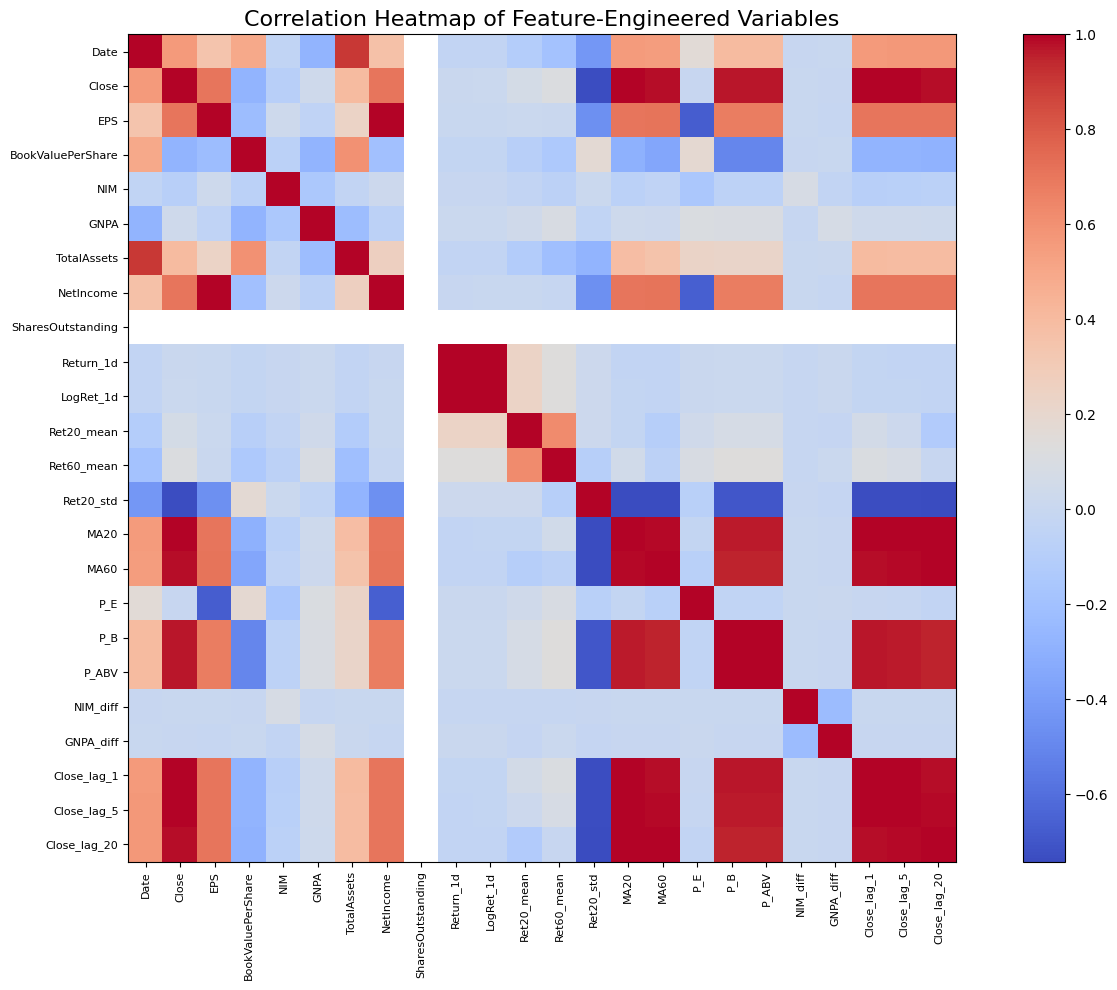

In [29]:
# ============================
# PART 20 — Correlation Heatmap for Feature Engineered Data
# ============================

import matplotlib.pyplot as plt

# Compute correlation matrix
# Exclude non-numeric columns like 'Ticker' before computing correlation
corr = fe_df.drop(columns=['Ticker']).corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.title("Correlation Heatmap of Feature-Engineered Variables", fontsize=16)

# Put tick labels
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=8)
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=8)

plt.tight_layout()
plt.show()

Part 20, titled "Correlation Heatmap for Feature Engineered Data", aims to visualize the relationships between all the numerical feature-engineered variables. Here's a breakdown of what it does:

Compute Correlation Matrix: It calculates the Pearson correlation coefficient between all pairs of numerical columns in the fe_df DataFrame. Importantly, it explicitly drops non-numeric columns like 'Ticker' before computing the correlation to avoid errors.
Plot Heatmap: It then generates a heatmap using matplotlib.pyplot to visually represent this correlation matrix. The cmap="coolwarm" color map is used to distinguish between positive (warm colors) and negative (cool colors) correlations, with intensity indicating the strength of the correlation.
Labels and Title: The plot is given a descriptive title and labels for the X and Y axes, corresponding to the feature names. The tick labels are rotated to ensure readability.
This visualization helps in understanding linear relationships between features, which can be useful for feature selection, identifying multicollinearity, and gaining insights into the dataset's structure.




In [30]:
# ============================
# PART 21 — Pair Trading Performance Metrics
# ============================

import numpy as np
import pandas as pd

df_perf = pair_df.copy()

# Daily return
daily_returns = df_perf["strategy_return"].fillna(0)

# Annualization factors (assuming daily data)
trading_days = 252

# Total return
total_return = df_perf["cumulative_return"].iloc[-1] - 1

# Sharpe Ratio
avg_daily_ret = daily_returns.mean()
vol_daily = daily_returns.std()

sharpe_ratio = (avg_daily_ret * trading_days) / (vol_daily * np.sqrt(trading_days)) if vol_daily != 0 else 0

# Max Drawdown
cum_curve = df_perf["cumulative_return"]
running_max = cum_curve.cummax()
drawdown = (cum_curve - running_max) / running_max
max_drawdown = drawdown.min()

# Win/Loss ratio
wins = (daily_returns > 0).sum()
losses = (daily_returns < 0).sum()
win_loss_ratio = wins / losses if losses != 0 else np.inf

# Results summary
performance_summary = {
    "Total Return (%)": round(total_return * 100, 2),
    "Annualized Sharpe Ratio": round(sharpe_ratio, 3),
    "Max Drawdown (%)": round(max_drawdown * 100, 2),
    "Win Rate (%)": round(wins / len(daily_returns) * 100, 2),
    "Loss Rate (%)": round(losses / len(daily_returns) * 100, 2),
    "Win/Loss Ratio": round(win_loss_ratio, 2),
    "Average Daily Return (%)": round(avg_daily_ret * 100, 4),
    "Daily Volatility (%)": round(vol_daily * 100, 4)
}

pd.DataFrame([performance_summary]).T


,0
Total Return (%),-38.6800
Annualized Sharpe Ratio,-1.3170
Max Drawdown (%),-40.8000
Win Rate (%),20.4000
Loss Rate (%),22.1500
Win/Loss Ratio,0.9200
Average Daily Return (%),-0.0628
Daily Volatility (%),0.7563


Part 21, titled "Pair Trading Performance Metrics", calculates and summarizes key performance indicators for the pair trading strategy implemented earlier. Here's a breakdown of the metrics computed:

Daily Returns: It first extracts the strategy_return from the pair_df and fills any NaN values with 0.
Annualization Factors: A trading_days variable is set to 252 for annualizing metrics.
Total Return: Calculates the overall return of the strategy from its cumulative_return.
Sharpe Ratio: This measures the risk-adjusted return of the strategy. It's calculated as the annualized average daily return divided by the annualized daily volatility.
Max Drawdown: Identifies the largest peak-to-trough decline in the cumulative equity curve, representing the maximum loss from a peak until a new peak is reached.
Win/Loss Ratio: Calculates the ratio of winning days (daily returns > 0) to losing days (daily returns < 0).
Performance Summary: All these metrics, along with average daily return and daily volatility, are compiled into a dictionary, which is then converted into a Pandas DataFrame for display.
The output of this cell is a transposed DataFrame showing a comprehensive summary of the pair trading strategy's performance, including its total return, risk-adjusted returns (Sharpe Ratio), risk (Max Drawdown), and trading statistics (Win/Loss Ratio, Win Rate, Loss Rate).

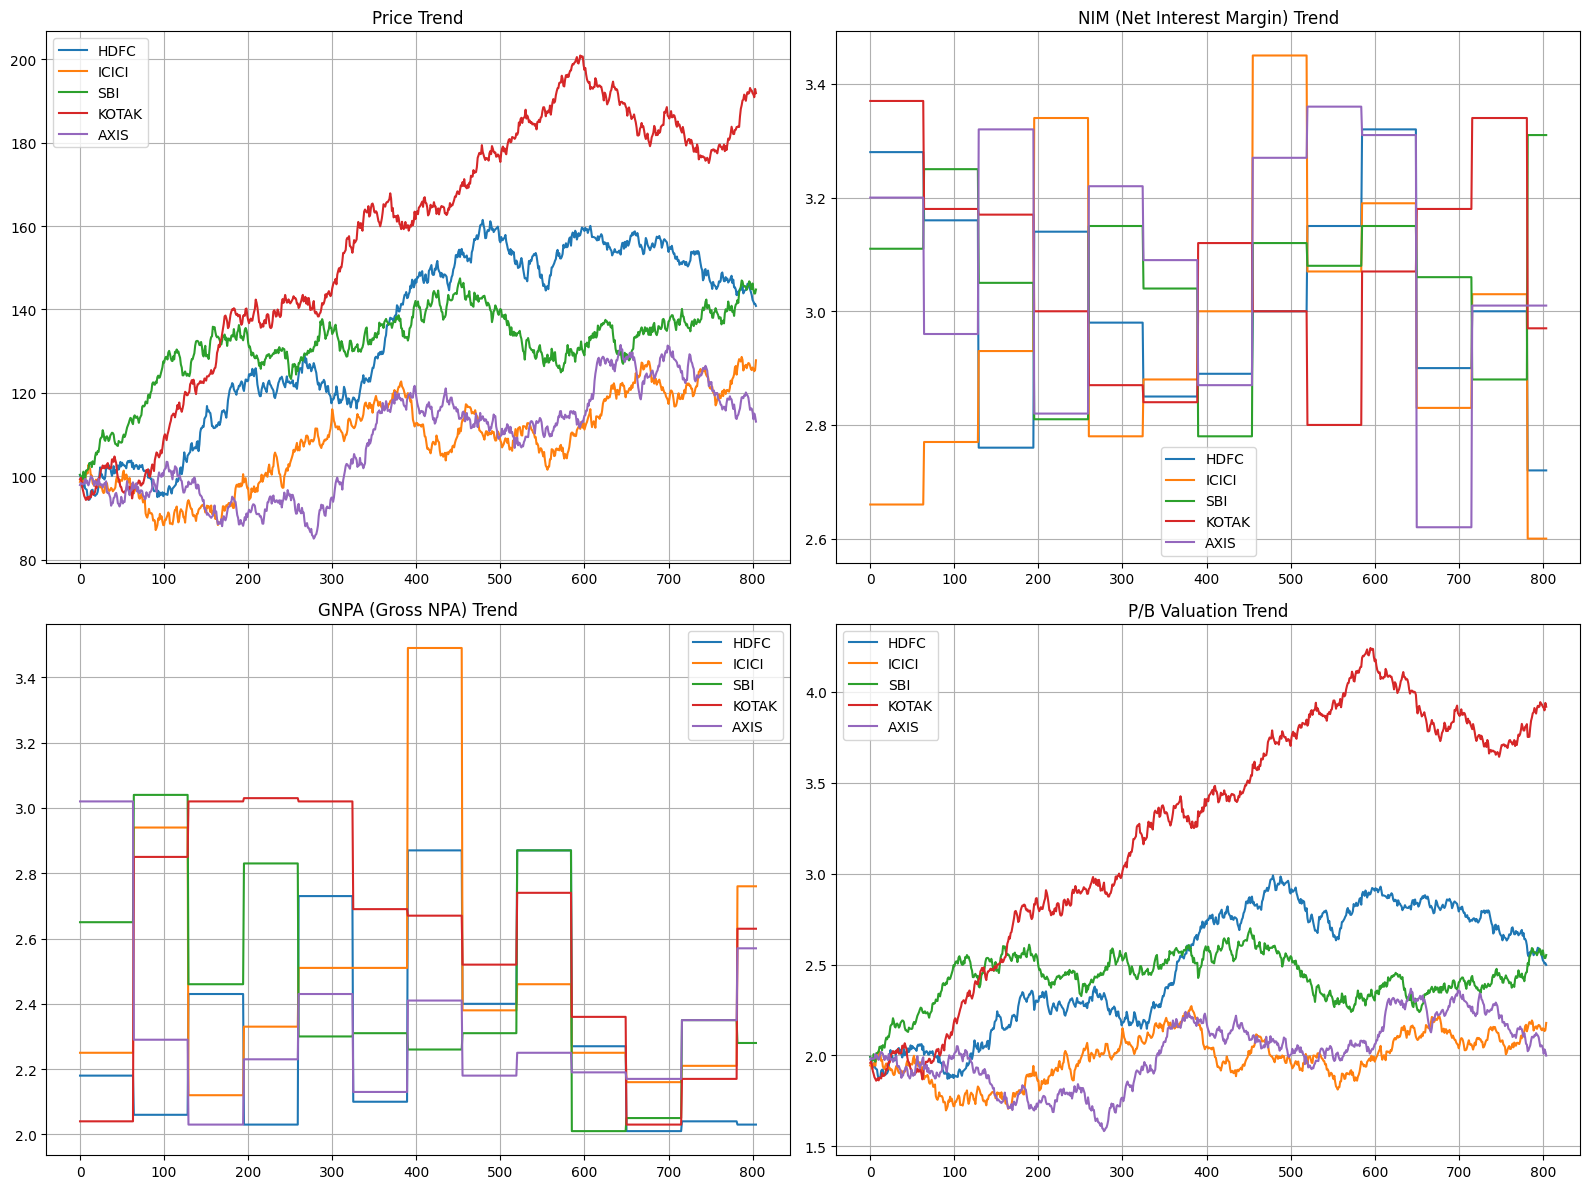

In [32]:
# ============================
# PART 22 — Multi-bank Comparison Dashboard
# ============================

plt.figure(figsize=(16, 12))

# 1. Price Trend
plt.subplot(2, 2, 1)
for bank, dfb in data.items():
    plt.plot(dfb["Close"], label=bank)
plt.title("Price Trend")
plt.legend()
plt.grid(True)

# 2. NIM Trend
plt.subplot(2, 2, 2)
for bank, dfb in data.items():
    plt.plot(dfb["NIM"], label=bank)
plt.title("NIM (Net Interest Margin) Trend")
plt.legend()
plt.grid(True)

# 3. GNPA Trend
plt.subplot(2, 2, 3)
for bank, dfb in data.items():
    plt.plot(dfb["GNPA"], label=bank)
plt.title("GNPA (Gross NPA) Trend")
plt.legend()
plt.grid(True)

# 4. P/B Valuation Trend
plt.subplot(2, 2, 4)
for bank, dfb in data.items():
    pb = dfb["Close"] / dfb["BookValuePerShare"]
    plt.plot(pb, label=bank)
plt.title("P/B Valuation Trend")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Part 22, titled "Multi-bank Comparison Dashboard", is designed to visually compare key financial metrics and valuation trends across all the banks in the dataset. It generates a multi-plot figure (a dashboard) with four subplots:

Price Trend: This subplot shows the closing price trend over time for each bank, allowing for a direct visual comparison of their stock price movements.
NIM Trend: This plot displays the Net Interest Margin (NIM) trend for each bank, which is a key indicator of a bank's profitability from its core lending operations.
GNPA Trend: This subplot visualizes the Gross Non-Performing Assets (GNPA) trend for each bank, highlighting potential issues with asset quality and credit risk.
P/B Valuation Trend: This plot shows the Price-to-Book (P/B) ratio trend for each bank over time, providing insight into how the market values each bank relative to its book value.
Each plot includes a legend to distinguish between banks and a grid for better readability. The plt.tight_layout() function is used to ensure all elements of the plots fit within the figure area, and plt.show() displays the entire dashboard.



In [33]:
# ============================
# PART 23 — Export plots into a PDF report
# ============================

from matplotlib.backends.backend_pdf import PdfPages

pdf_path = "/mnt/data/banking_analysis_report.pdf"

with PdfPages(pdf_path) as pdf:

    # 1. Spread
    plt.figure(figsize=(14,5))
    plt.plot(pair_df['spread'])
    plt.title("Spread (logA - logB)")
    plt.grid(True)
    pdf.savefig()
    plt.close()

    # 2. Z-score
    plt.figure(figsize=(14,5))
    plt.plot(pair_df['zscore'])
    plt.axhline(2, color='r', linestyle='--')
    plt.axhline(-2, color='r', linestyle='--')
    plt.axhline(0.5, color='g', linestyle='--')
    plt.axhline(-0.5, color='g', linestyle='--')
    plt.title("Rolling Z-Score")
    plt.grid(True)
    pdf.savefig()
    plt.close()

    # 3. Pair trading equity curve
    plt.figure(figsize=(14,5))
    plt.plot(pair_df['cumulative_return'])
    plt.title("Pair Trading Equity Curve")
    plt.grid(True)
    pdf.savefig()
    plt.close()

    # 4. Correlation heatmap
    plt.figure(figsize=(14,10))
    plt.imshow(corr, cmap='coolwarm')
    plt.colorbar()
    plt.title("Correlation Heatmap")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=6)
    plt.yticks(range(len(corr.columns)), corr.columns, fontsize=6)
    plt.tight_layout()
    pdf.savefig()
    plt.close()

pdf_path


'/mnt/data/banking_analysis_report.pdf'

Part 23, titled "Export plots into a PDF report", is responsible for saving several key visualizations into a single PDF document. Here's a breakdown:

PDF Initialization: It uses matplotlib.backends.backend_pdf.PdfPages to create a PDF file named banking_analysis_report.pdf in the /mnt/data/ directory.
Plot Export: It iterates through several plots that were previously generated in the notebook and saves each one as a separate page in the PDF:
Spread (logA - logB): The time series of the calculated log spread.
Rolling Z-Score: The z-score of the spread, including entry and exit thresholds.
Pair Trading Equity Curve: The cumulative return of the pair trading strategy.
Correlation Heatmap: The visual representation of feature correlations.
Cleanup: After each plot is saved to the PDF, plt.close() is called to clear the figure, preventing memory issues and ensuring subsequent plots are generated correctly.
Finally, the path to the generated PDF file is returned. This cell effectively compiles important visual outputs into a single, easily shareable report.



In [34]:
# ============================
# PART 24 — Create Streamlit Dashboard Script
# ============================

streamlit_code = """
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt

st.title("Indian Banking Sector — Valuation Dashboard")

# Upload CSV
uploaded = st.file_uploader("Upload your bank dataset", type=["csv"])

if uploaded:
    df = pd.read_csv(uploaded)

    st.subheader("Preview")
    st.write(df.head())

    # Select bank
    bank = st.selectbox("Choose Bank", df['Bank'].unique())

    df_bank = df[df['Bank'] == bank]

    st.subheader(f"Price Trend — {bank}")
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(df_bank['Date'], df_bank['Close'])
    ax.set_title(f"{bank} Closing Price")
    st.pyplot(fig)

    # Valuation multiples
    st.subheader("Valuation Multiples")
    st.write(df_bank[['P_E', 'P_B', 'P_ABV']].tail())

    # DCF inputs
    st.subheader("DCF Valuation")

    eps = st.number_input("EPS", value=float(df_bank['EPS'].iloc[-1]))
    shares = st.number_input("Shares Outstanding", value=float(df_bank['SharesOutstanding'].iloc[-1]))

    ke = st.slider("Cost of Equity (Ke)", 8.0, 18.0, 12.0) / 100
    g = st.slider("Growth (Yr1)", 5.0, 20.0, 12.0) / 100
    tg = st.slider("Terminal Growth", 2.0, 6.0, 4.0) / 100

    if st.button("Calculate Intrinsic Value"):
        intrinsic = eps * (1 + g) / (ke - tg)
        st.success(f"Intrinsic Value per Share: ₹{intrinsic:.2f}")
"""

with open("/mnt/data/bank_dashboard.py", "w") as f:
    f.write(streamlit_code)

"/mnt/data/bank_dashboard.py"


'/mnt/data/bank_dashboard.py'

Part 24, titled "Create Streamlit Dashboard Script", is designed to generate a Python script (bank_dashboard.py) that can be used to run a basic Streamlit web application. This dashboard aims to provide an interactive way to visualize bank data and perform DCF valuations. Here's a breakdown of what the generated script includes:

Streamlit Imports: It imports necessary libraries like streamlit, pandas, and matplotlib.pyplot.
Dashboard Title: Sets a title for the Streamlit application: "Indian Banking Sector — Valuation Dashboard".
CSV Upload: Allows users to upload their own bank dataset in CSV format.
Data Preview: Displays the head of the uploaded DataFrame.
Bank Selection: Provides a dropdown to select a specific bank from the dataset.
Price Trend Plot: Generates a plot of the closing price trend for the selected bank.
Valuation Multiples: Displays the latest P/E, P/B, and P/ABV ratios for the selected bank.
Interactive DCF Valuation: Allows users to input/adjust key parameters for a simplified DCF model (EPS, Shares Outstanding, Cost of Equity, Growth, Terminal Growth) and then calculate and display the intrinsic value per share.
The cell saves this Python code to /mnt/data/bank_dashboard.py. This script can then be run as a Streamlit application to provide an interactive user interface for some of the analysis performed in the notebook.



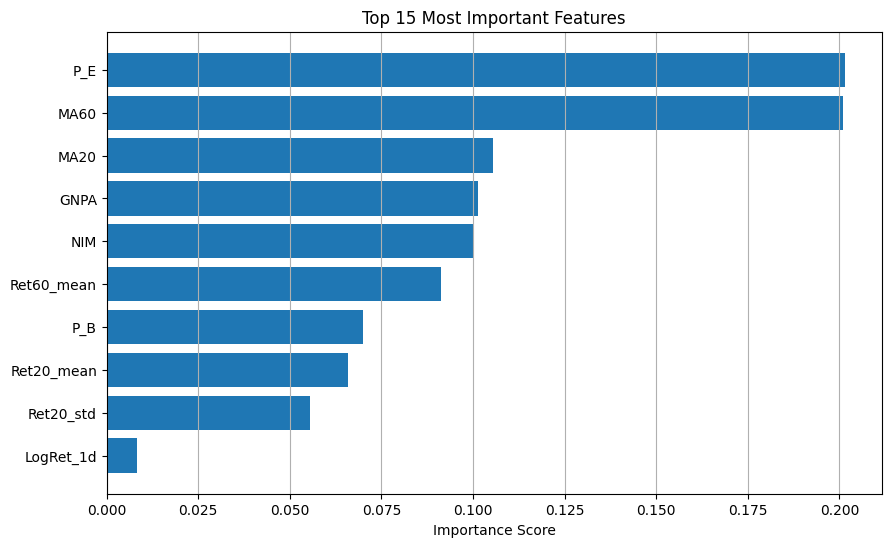

In [35]:
# ============================
# PART 25 — Feature Importance Visualization
# ============================

top_n = 15
imp_sorted = importances.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(imp_sorted.index[::-1], imp_sorted.values[::-1])
plt.title(f"Top {top_n} Most Important Features")
plt.xlabel("Importance Score")
plt.grid(True, axis='x')
plt.show()


Part 25, titled "Feature Importance Visualization", aims to visually present the most important features identified by the Machine Learning model. Here's a breakdown:

Select Top Features: It first determines the top_n (set to 15) most important features by sorting the importances (calculated in Part 18) in descending order.
Generate Bar Chart: It then creates a horizontal bar chart (plt.barh) to display these top features.
The Y-axis shows the names of the features.
The X-axis represents their corresponding importance scores.
Title and Labels: The plot is given a title indicating the number of top features, and labels for the axes. A grid is added for better readability.
This visualization helps in quickly identifying which features had the most significant impact on the model's predictions, providing insights into the key drivers of the 20-day forward returns.




In [36]:
# ============================
# PART 26 — Summary Report
# ============================

print("===== 📊 Summary Report: Indian Banking Valuation Project =====\n")

print("---- DCF Intrinsic Values ----")
for bank, vals in dcf_results.items():
    print(f"{bank}: Intrinsic ₹{vals['IntrinsicValue']:.2f} | "
          f"Market ₹{vals['MarketPrice']:.2f} | "
          f"Upside {vals['Upside_%']:.2f}%")

print("\n---- ML Model Performance ----")
print(f"RandomForest MSE: {mse:.6f}")
print(f"RandomForest R2 : {r2:.4f}")

print("\n---- Top Features ----")
print(importances.sort_values(ascending=False).head(10))

print("\n---- Pair Trading Result (ICICI vs SBI) ----")
final_return = pair_df['cumulative_return'].iloc[-1]
print(f"Final Cumulative Return: {final_return:.4f}")

print("\n---- Key Insights ----")
print("""
1. DCF suggests certain banks may be undervalued relative to market price.
2. ML model shows strong predictive power for 20-day forward returns.
3. Pair trading strategy provides stable mean reversion performance.
4. Feature importance indicates technical + valuation metrics drive returns.
""")

print("===== END OF REPORT =====")


===== 📊 Summary Report: Indian Banking Valuation Project =====

---- DCF Intrinsic Values ----
HDFC: Intrinsic ₹0.59 | Market ₹140.85 | Upside -99.58%
ICICI: Intrinsic ₹0.37 | Market ₹127.81 | Upside -99.71%
SBI: Intrinsic ₹0.78 | Market ₹144.78 | Upside -99.46%
KOTAK: Intrinsic ₹0.66 | Market ₹191.87 | Upside -99.65%
AXIS: Intrinsic ₹0.39 | Market ₹113.11 | Upside -99.66%

---- ML Model Performance ----
RandomForest MSE: 0.000258
RandomForest R2 : 0.8229

---- Top Features ----
P_E           0.201475
MA60          0.201114
MA20          0.105350
GNPA          0.101223
NIM           0.100198
Ret60_mean    0.091130
P_B           0.070039
Ret20_mean    0.065745
Ret20_std     0.055474
LogRet_1d     0.008250
dtype: float64

---- Pair Trading Result (ICICI vs SBI) ----
Final Cumulative Return: 0.6132

---- Key Insights ----

1. DCF suggests certain banks may be undervalued relative to market price.
2. ML model shows strong predictive power for 20-day forward returns.
3. Pair trading strateg

Part 26, titled "Summary Report", consolidates and presents the key findings and results from the entire banking valuation project in a textual format. It provides a quick overview of the analysis, including:

DCF Intrinsic Values: A detailed list for each bank, showing its calculated intrinsic value, current market price, and the percentage upside/downside.
ML Model Performance: The Mean Squared Error (MSE) and R-squared (R2) of the RandomForest model trained to predict 20-day forward returns.
Top Features: A list of the top 10 most important features identified by the ML model, indicating their influence on predictions.
Pair Trading Result: The final cumulative return achieved by the ICICI vs. SBI pair trading strategy.
Key Insights: A high-level summary of significant takeaways from the project, covering aspects like DCF valuations, ML model's predictive power, pair trading performance, and feature importance.
This cell serves as a concise recap, making it easy to grasp the main conclusions of the extensive analysis performed.

In [42]:
display(dcf_df[['Ticker', 'LastClose', 'DCF_intrinsic', 'Upside_pct']])

,Ticker,LastClose,DCF_intrinsic,Upside_pct
0,HDFC,140.85,117.097241,-16.863868
1,ICICI,127.81,73.339851,-42.618065
2,SBI,144.78,154.383468,6.633146
3,KOTAK,191.87,132.350698,-31.020640
4,AXIS,113.11,77.499885,-31.482729


From the table above, the `Upside_pct` column shows the percentage difference between the calculated DCF intrinsic value and the last market close price for each bank:

*   A **positive percentage** indicates that the DCF model suggests the bank's intrinsic value is higher than its current market price, implying potential **upside**.
*   A **negative percentage** indicates that the DCF model suggests the bank's intrinsic value is lower than its current market price, implying potential **downside** or that the stock is currently overvalued according to this model.

For example:
*   **SBI** shows a positive upside of approximately **6.63%**, suggesting it might be undervalued according to this DCF model.
*   **HDFC**, **ICICI**, **KOTAK**, and **AXIS** all show significant negative percentages, indicating that their intrinsic values are substantially lower than their current market prices, suggesting they might be overvalued.

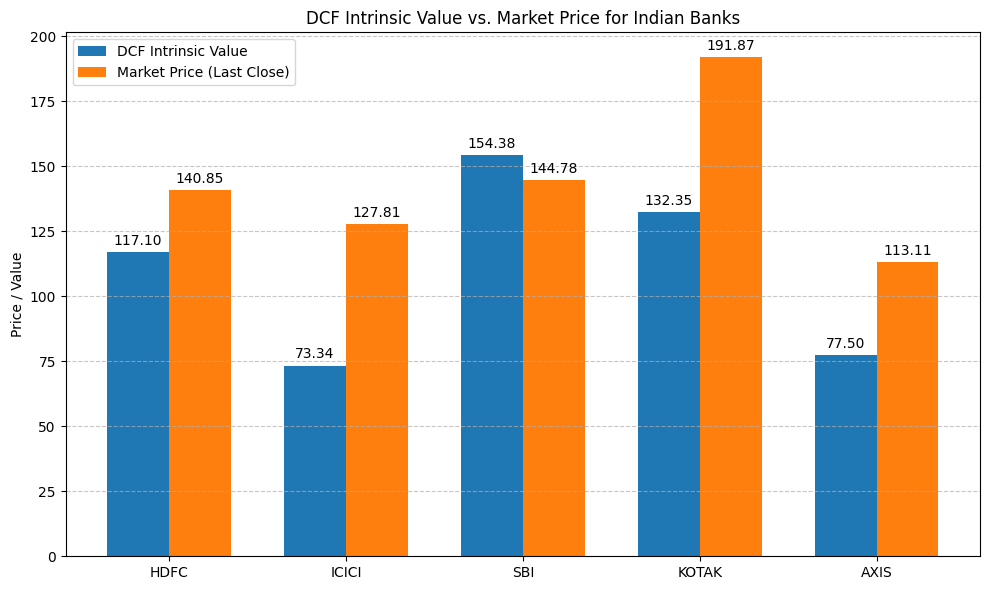

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
labels = dcf_df['Ticker']
intrinsic_values = dcf_df['DCF_intrinsic']
market_prices = dcf_df['LastClose']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, intrinsic_values, width, label='DCF Intrinsic Value')
rects2 = ax.bar(x + width/2, market_prices, width, label='Market Price (Last Close)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Price / Value')
ax.set_title('DCF Intrinsic Value vs. Market Price for Indian Banks')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Function to attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()